# How to use `scivision`

In this notebook, we will:

1. Demonstrate using the scivision [Python API](https://scivision.readthedocs.io/en/latest/api.html) to load several pretrained image classification models
2. Use the scivision catalog to find a matching dataset, which the model can be run on
3. Run the model on the data, performing simple model inference
4. Use the scivision catalog to find another model that can be run on the same dataset

First let's import some things from scivision: `default_catalog` is a scivision **catalog** that will let us discover models and datasets, and `load_pretrained_model` provides a convenient way to load and run a model.

In [1]:
from scivision import default_catalog, load_pretrained_model

## Inspecting our model in the scivision catalog

A scivision catalog is a collection of **models** and **datasources**.

For this example, we want to find datasources compatible with the model catalog entry "image-classifiers".  But first, let's use the catalog to retrive the "image-classifiers" repository url and take a look at the data contained in the *default catalog* (the built-in catalog, distributed as part of scivision) and see how this is structured.

In [2]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "image-classifiers"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

FlexibleUrl('https://github.com/alan-turing-institute/scivision_classifier', scheme='https', host='github.com', tld='com', host_type='domain', path='/alan-turing-institute/scivision_classifier')

In [3]:
# Inspecting model entry and its metadata in the default catalog
models_catalog[models_catalog.name == "image-classifiers"]

,name,description,tasks,url,pkg_url,format,scivision_usable,pretrained,labels_required,institution,tags
6,image-classifiers,Scivision plugin for the image-classifiers pac...,"(TaskEnum.classificiation,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,True,False,"(alan-turing-institute,)","(classification, 2D, image)"


## Loading the model

Some model entries in the scivision catalog contain a single loadable model. Here, let's load the "image-classifiers" entry, which contains each of the models in the [image-classifiers](https://pypi.org/project/image-classifiers/) package. We can do this with the `load_pretrained_model` function. We'll load 2 models (`resnet18` and `densenet121`).

Note: the "model_selection" arg is not mandatory and will have a default value for any model catalog entries that have more than one model - for model catalog entries with a single model, this need not be set:

In [4]:
# Note: when loading this model repo for the first time you'll need to add the allow_install=True flag
resnet_model = load_pretrained_model(model_repo, model_selection='resnet18', allow_install=True)
densenet_model = load_pretrained_model(model_repo, model_selection='densenet121')

2023-06-27 15:52:23.925836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# let's explore one of the model objects
resnet_model

scivision.PretrainedModel( 
  module='scivision_classifier', 
  model='resnet18', 
  source='https://github.com/alan-turing-institute/scivision_classifier' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

Later, we'll use these models to make predictions on image data found in the scivision catalog.

## Query the default scivision data catalog

Now let's use the `default_catalog` to identify datasources in the catalog that are compatible with our models (based on `tasks`, `format` and `labels_provided`/`labels_required`).

In [6]:
compatible_datasources = default_catalog.compatible_datasources("image-classifiers").to_dataframe()
compatible_datasources

,name,description,tasks,labels_provided,domains,url,format,institution,tags
2,scivision-test-data,Test data comprised of individual images inclu...,"(TaskEnum.object_detection, TaskEnum.segmentat...",True,"(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,"(Wikipedia by Erik Veland,)","(demo,)"
3,cefas-plankton,Sample dataset of Plankton required to demonst...,(TaskEnum.classificiation),True,"(computer-vision,)",https://raw.githubusercontent.com/alan-turing-...,image,"(Centre for Environment, Fisheries and Aquacul...","(2D, plankton, ecology, environmental-science)"
4,coastal-edges,Sample dataset of satellite RGB imagery over t...,"(TaskEnum.segmentation, TaskEnum.classificiation)",False,"(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."
6,sentinel2_stac,Data plugin for accessing Sentinel-2 Cloud-Opt...,"(TaskEnum.segmentation, TaskEnum.classificiation)",False,"(computer-vision, earth-observation, ecology)",https://github.com/alan-turing-institute/scivi...,image,"(The Alan Turing Institute,)","(satellite, aerial, remote-sensing, ecology, e..."
7,flowers,"The 102 flowers dataset, created by Visual Geo...",(TaskEnum.classificiation),True,"(computer-vision, ecology)",https://github.com/nbarlowATI/flowers_data_repo,image,"(The Alan Turing Institute,)","(ecology, environmental-science)"
8,butterflies,The Butterfly Image Classification Kaggle chal...,(TaskEnum.classificiation),True,"(computer-vision, ecology)",https://github.com/nbarlowATI/butterfly_data_repo,image,"(The Alan Turing Institute,)","(butterflies, insects, animals, ecology)"
9,Parakeet,Synthetic cryoEM data from Parakeet,"(TaskEnum.object_detection, TaskEnum.segmentat...",False,None,https://github.com/rosalindfranklininstitute/s...,image,"(Rosalind Franklin Institute,)","(CryoEM,)"
10,cell-cycle-scivision,Crops of H2B-FP stained nuclei in MDCK cells.,(TaskEnum.classificiation),True,"(optical microscopy, cell biology)",https://github.com/lowe-lab-ucl/cell-cycle-sci...,image,"(UCL,)",()
12,MapReader_Data_SIGSPATIAL_2022,Here we share gold standard annotations and ou...,(TaskEnum.classificiation),True,"(history, urban-planning)",https://github.com/alan-turing-institute/mapre...,image,"(The Alan Turing Institute,)","(2D, humanities)"


Let's use `scivision-test-data`, an image dataset containing a single image of a Koala.

In [7]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'scivision-test-data']
target_datasource

,name,description,tasks,labels_provided,domains,url,format,institution,tags
2,scivision-test-data,Test data comprised of individual images inclu...,"(TaskEnum.object_detection, TaskEnum.segmentat...",True,"(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,"(Wikipedia by Erik Veland,)","(demo,)"


## Load the dataset

Now let's load the dataset using the scivision python API, specifically the [load_dataset](https://scivision.readthedocs.io/en/latest/api.html#scivision.io.reader.load_dataset) function, which takes as input the url of the data repository (structured as per [this template](https://scivision.readthedocs.io/en/latest/data_repository_template.html)), which we can get from the target datasource:

In [8]:
from scivision import load_dataset

In [9]:
data_url = target_datasource['url'].item()

The returned data config object of the`load_dataset` function is an "intake catalog". You can read our [documentation](https://scivision.readthedocs.io/en/latest/data_repository_template.html#data-config-file) to understand this better, but for now, let's inspect this config:

In [10]:
data_config = load_dataset(data_url)
data_config

data:
  args:
    path: https://raw.githubusercontent.com/alan-turing-institute/scivision-test-data/main/.scivision/data.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [11]:
list(data_config)

['test_image', 'airport', 'dog_cat']

Clicking the `path` link to the location of this data config file online (in the dataset repo) reveals that there is one data source called `test_image`, and that the `intake_xarray.image.ImageSource` "intake driver" is being used. We can retrive the test image data in an image format which the model will accept, like so:

In [12]:
data_config['test_image']()

test_image:
  args:
    urlpath: https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Cutest_Koala.jpg/262px-Cutest_Koala.jpg
  description: Load a single Koala
  driver: intake_xarray.image.ImageSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/alan-turing-institute/scivision-test-data/main/.scivision


In [13]:
test_image = data_config.test_image().to_dask() # The xarray.DataArray is one format accepted by the our models
test_image

/Users/ifenton/opt/anaconda3/envs/scivision_comp/lib/python3.9/site-packages/xarray/core/dataarray.py:1323: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


<xarray.DataArray (y: 240, x: 262, channel: 3)>
dask.array<xarray-<this-array>, shape=(240, 262, 3), dtype=uint8, chunksize=(240, 262, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 231 232 233 234 235 236 237 238 239
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 253 254 255 256 257 258 259 260 261
  * channel  (channel) int64 0 1 2

Let's take a look at the image with `matplotlib`:

In [14]:
import matplotlib.pyplot as plt

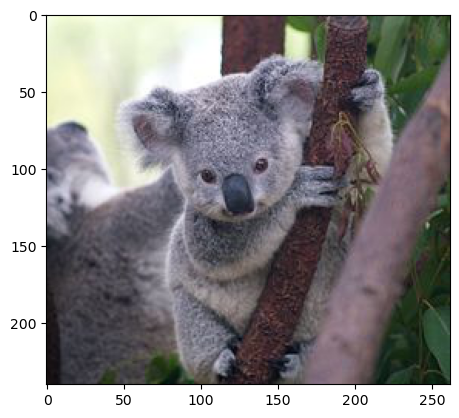

In [15]:
plt.imshow(test_image)

## Model predictions

Now let's use the loaded model on the test image data we found in the via catalog.

In [16]:
resnet_model.predict(test_image)

1/1 [==============================] - 0s 282ms/step


'koala : 99.80%'

In [17]:
densenet_model.predict(test_image)

1/1 [==============================] - 1s 1s/step


'koala : 99.73%'

As you can see, the models have given predictions for the test image, with a confidence score. Check out the code in the [model repo](https://github.com/alan-turing-institute/scivision_classifier) to see how this was determined!

## Query the default scivision model catalog

Using our test Koala image dataset, let's search the scivision default catalog for other models that can be used with it:

In [18]:
compatible_models = default_catalog.compatible_models("scivision-test-data").to_dataframe()
compatible_models

,name,description,tasks,url,pkg_url,format,scivision_usable,pretrained,labels_required,institution,tags
0,stardist,Single class object detection and segementatio...,"(TaskEnum.object_detection, TaskEnum.segmentat...",https://github.com/stardist/stardist,git+https://github.com/stardist/stardist.git@main,image,False,True,True,"(epfl,)","(2D, 3D, optical-microscopy, xray, microtomogr..."
1,PlantCV,Open-source image analysis software package ta...,"(TaskEnum.segmentation, TaskEnum.thresholding,...",https://github.com/danforthcenter/plantcv,git+https://github.com/danforthcenter/plantcv@...,image,False,True,True,"(danforthcenter,)","(2D, hyperspectral, multispectral, near-infrar..."
2,greenotyper,Greenotyper is an image analysis tool for larg...,"(TaskEnum.segmentation,)",https://github.com/MarniTausen/Greenotyper,git+https://github.com/MarniTausen/Greenotyper...,image,False,True,True,"(MarniTausen,)","(2D, multispectral, plant-phenotyping, climate..."
3,mapreader-plant,automated detection of plant patches in images...,"(TaskEnum.classificiation, TaskEnum.object_det...",https://github.com/alan-turing-institute/mapre...,git+https://github.com/alan-turing-institute/m...,image,True,True,False,"(alan-turing-institute,)","(2D, plant, phenotype, rgb, biology, agriculture)"
4,resnet50-plankton,automated classification of plankton images co...,"(TaskEnum.classificiation,)",https://github.com/alan-turing-institute/plank...,git+https://github.com/alan-turing-institute/p...,image,True,True,False,"(alan-turing-institute, cefas, plankton-analyt...","(2D, plankton, ecology, environmental-science)"
5,vedge-detector,automated detection of coastal vegetation edge...,"(TaskEnum.segmentation,)",https://github.com/MartinSJRogers/VEdge_Detect...,git+https://github.com/MartinSJRogers/VEdge_De...,image,True,True,False,"(cambridge-university, birkbeck-university)","(2D, satellite, remote-sensing, ecology, envir..."
6,image-classifiers,Scivision plugin for the image-classifiers pac...,"(TaskEnum.classificiation,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,True,False,"(alan-turing-institute,)","(classification, 2D, image)"
7,huggingface-classifiers,Selection of image classifiers taken from http...,"(TaskEnum.classificiation,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,True,False,"(alan-turing-institute, huggingface)","(classification, 2D, image)"
8,huggingface-segmentation,Selection of segmentation algorithms taken fro...,"(TaskEnum.segmentation,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,True,False,"(alan-turing-institute, huggingface)",()
9,huggingface-object-detection,Selection of object detection algorithms taken...,"(TaskEnum.object_detection,)",https://github.com/alan-turing-institute/scivi...,git+https://github.com/alan-turing-institute/s...,image,True,True,False,"(alan-turing-institute, huggingface)",()


The `huggingface-classifiers` catalog entry can be used to load some of the most popular image classification models from [Hugging Face](https://huggingface.co/models?pipeline_tag=image-classification&sort=downloads). See the list of included models in the [model repo](https://github.com/alan-turing-institute/scivision_huggingface). As before, let's load one of the named models and run it on our test image:

In [19]:
huggingface_repo = models_catalog[models_catalog.name == "huggingface-classifiers"].url.item()
microsoft_model = load_pretrained_model(huggingface_repo, model_selection='microsoft_swin_tiny_patch4_window7_224', allow_install=True)

/Users/ifenton/opt/anaconda3/envs/scivision_comp/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740371165/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
microsoft_model.predict(test_image)

'Predicted class: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus'